In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

<h1>Walsh function decomposition:</h1>

In [2]:
def walsh(order,x):
    res = 1
    x = np.modf(x)[0]
    x *= 2
    while order>0:
        res *= (-1)**((order%2)*np.modf(x)[1])
        order //= 2
        x = np.modf(x)[0]
        x *= 2
    return res

def walsh_coeff(f,order,M):
    sampling_points = np.linspace(0,1,num=M,endpoint=False)
    sampled_values = [walsh(order,i) for i in sampling_points]
    return np.dot(f(sampling_points),sampled_values)/M

def walsh_approximator(f,n,max_terms=1024):
    #Returns a function f^eps, the Walsh approximation of f
    # m = np.floor(np.log2(1/eps))+1
    M = int(2**n)
    # print('This is M',M)
    all_coeffs = [walsh_coeff(f,j,M) for j in range(M)]
    #Keep only largest max_terms coeffs sorted by absolute value
    largest = sorted(zip(np.abs(all_coeffs),all_coeffs,range(M)),reverse=True)[:max_terms]
    coeffs = [coeff for _,coeff,idx in largest]
    orders = [idx for _,coeff,idx in largest]
    def approximated_f(x):
        values = [walsh(j,x) for j in orders]
        return np.dot(coeffs,values)
    return approximated_f, coeffs, orders

def get_interp(amp_list):
    return interp1d(np.linspace(0,1,num=amp_list.shape[0],endpoint=False),amp_list)

In [3]:
n_qubits = 2
amp_list = np.abs(np.random.normal(0, 1, 2**n_qubits))
amp_list = amp_list/np.linalg.norm(amp_list)
f = get_interp(amp_list)

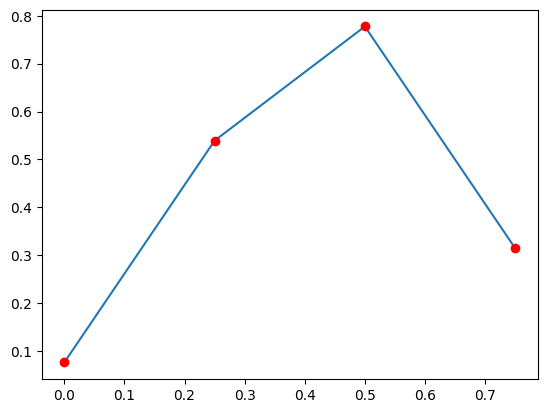

In [4]:
test_points = np.linspace(0,1,num=amp_list.shape[0],endpoint=False)
plt.scatter(np.linspace(0,1,num=amp_list.shape[0],endpoint=False),amp_list,c='red',zorder=2)
plt.plot(test_points,f(test_points),zorder=1)
plt.show()

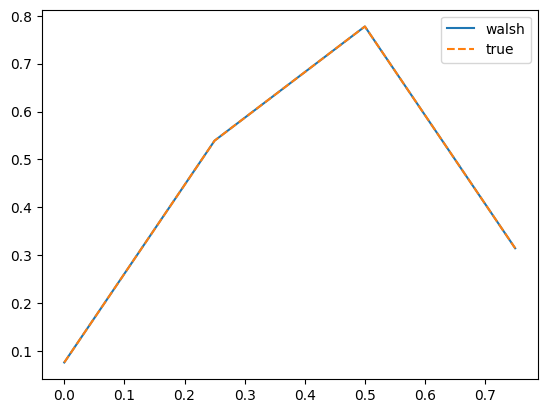

In [5]:
test_points = np.linspace(0,1,num=amp_list.shape[0],endpoint=False)
approx_f, coeffs, orders = walsh_approximator(f,n_qubits)
sampled_points = np.array([approx_f(i) for i in test_points])
plt.plot(test_points,sampled_points,label='walsh')
plt.plot(test_points,f(test_points),label='true',linestyle='--')
plt.legend()
plt.show()

<h1>Walsh state preparation:</h1>

In [3]:
def walsh_operator(wires,ancilla,coeff,eps0):
    for q in wires[:-1]:
        qml.Toffoli([ancilla[0],q,wires[-1]])
    qml.CRZ(-2*coeff*eps0,wires=[ancilla[0],wires[-1]])
    for q in reversed(wires[:-1]):
        qml.Toffoli([ancilla[0],q,wires[-1]])

def walsh_unitary(f,wires,ancilla,eps0,k,max_terms):
    approx_f,coeffs,orders = walsh_approximator(f,k,max_terms)
    for coeff,order in zip(coeffs,orders):
        bin_ord = list(np.binary_repr(order,width=len(wires)))
        bin_ord.reverse()
        bin_ord = np.array(bin_ord)
        indices = np.where(bin_ord == '1')
        on_wires = np.take_along_axis(np.array(wires),indices[0],0)
        if order>0:
            walsh_operator(on_wires,ancilla,coeff,eps0)
    return np.array(coeffs)[np.nonzero(np.array(orders)==0)]

def walsh_state_prep(wires,ancilla,f,eps0,k,max_terms):
    for wire in wires:
        qml.Hadamard(wire)
    qml.Hadamard(ancilla[0])
    zero_coeff = walsh_unitary(f,wires,ancilla,eps0,k,max_terms)
    if zero_coeff.size > 0:
        qml.RZ(1*zero_coeff[0]*eps0,wires=ancilla[0])
    qml.Hadamard(ancilla[0])
    qml.adjoint(qml.S)(ancilla[0])

In [398]:
num_qubits = 5
amp_list = np.abs(np.random.normal(0,1,2**num_qubits))
amp_list = amp_list/np.linalg.norm(amp_list)

In [416]:
dev = qml.device('default.qubit',wires=num_qubits+1)

@qml.qnode(dev)
def circuit(wires,ancilla,f,eps0,k,max_terms=1024):
    walsh_state_prep(wires,ancilla,f,eps0,k,max_terms)
    return qml.state()

In [4]:
plt.rcParams['text.usetex']=True

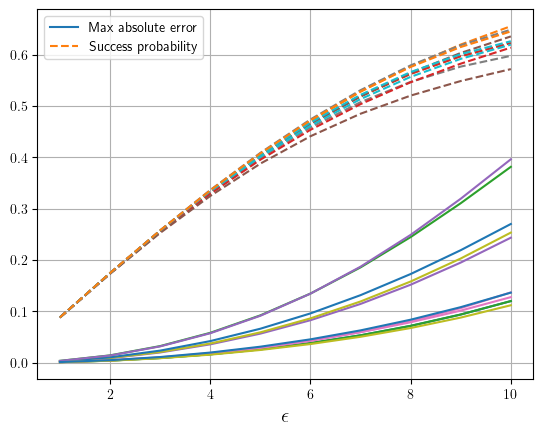

In [406]:
for i in range(10):
    amp_list = np.abs(np.random.normal(0,1,2**num_qubits))
    amp_list = amp_list/np.linalg.norm(amp_list)
    max_error = []
    prob = []
    samples = np.linspace(1,10,num=10)
    sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
    for e in samples:
        res = circuit(np.array(range(1,num_qubits+1)),np.array([0]),get_interp(amp_list),e,num_qubits)
        res_p = res[res.shape[0]//2:]
        prob.append(np.linalg.norm(res_p))
        res_pn = np.abs(res_p)/np.linalg.norm(res_p)
        max_error.append(np.max(np.abs(res_pn-get_interp(amp_list)(sample_points))))
    if i==0:
        plt.plot(samples,max_error,label='Max absolute error')
        plt.plot(samples,prob,linestyle='--',label='Success probability')      
    plt.plot(samples,max_error)
    plt.plot(samples,prob,linestyle='--')
plt.xlabel(r'$\epsilon$',fontsize=15)
plt.legend()
plt.grid()
plt.show()

In [36]:
res = circuit(np.array(range(1,num_qubits+1)),np.array([0]),get_interp(amp_list),6.5,num_qubits)

0.48827666858295254
[0.16417535 0.07132668 0.20083235 0.20951088 0.04064854 0.12064296
 0.03323858 0.0705219  0.06524963 0.34148426 0.12896461 0.31134985
 0.06048665 0.26298199 0.09841965 0.34513811 0.0344255  0.3291985
 0.22473255 0.16473106 0.14148214 0.13631184 0.05894519 0.23023695
 0.0258517  0.31790923 0.04748125 0.00250677 0.16057737 0.09317417
 0.02312129 0.06406926]


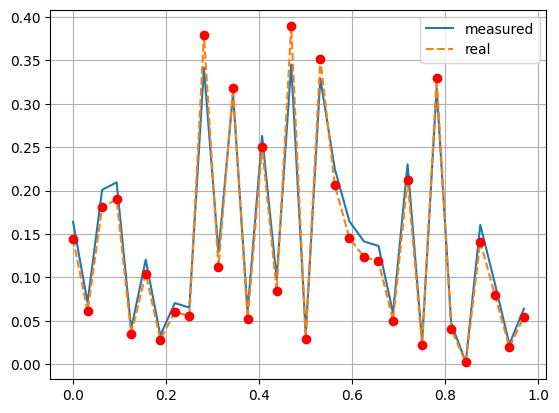

In [37]:
res_p = res[res.shape[0]//2:]
print(np.linalg.norm(res_p))
res_pn = np.abs(res_p)/np.linalg.norm(res_p)
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
print(res_pn)
plt.plot(sample_points,res_pn,label='measured')
plt.plot(sample_points,get_interp(amp_list)(sample_points),label='real',linestyle='--')
plt.scatter(sample_points,amp_list,c='red',zorder=2)
plt.legend()
plt.grid()
plt.show()

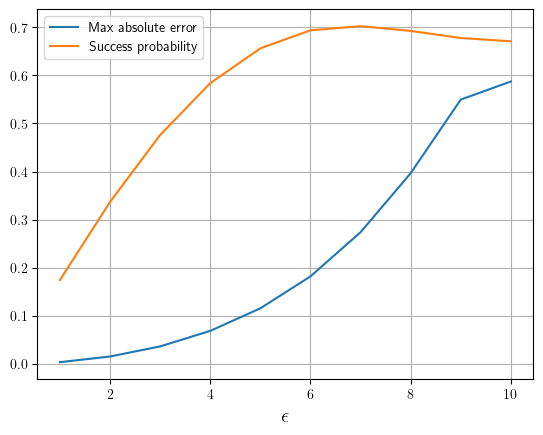

In [431]:
max_error = []
prob = []
samples = np.linspace(1,10,num=10)
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
for e in samples:
    res = circuit(np.array(range(1,num_qubits+1)),np.array([0]),get_interp(amp_list),e,num_qubits)
    res_p = res[res.shape[0]//2:]
    prob.append(np.linalg.norm(res_p))
    res_pn = np.abs(res_p)/np.linalg.norm(res_p)
    # print(res_pn)
    # print(get_interp(amp_list)(sample_points))
    max_error.append(np.max(np.abs(res_pn-get_interp(amp_list)(sample_points))))
plt.plot(samples,max_error,label='Max absolute error')
plt.plot(samples,prob,label='Success probability')
plt.xlabel(r'$\epsilon$',fontsize=15)
plt.legend()
plt.grid()
plt.show()

<h1>Running circuits on IBMQ:</h1>

In [5]:
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService
import pennylane_qiskit as qmlqiskit

In [6]:
provider = IBMProvider()
service = QiskitRuntimeService()

In [408]:
amp_list = np.abs(np.random.normal(0,1,2**num_qubits))
amp_list = amp_list/np.linalg.norm(amp_list)
print(amp_list)

[0.12787755 0.02232474 0.29006564 0.26871596 0.65356168 0.53247637
 0.33595946 0.05709531]


In [7]:
amp_list = np.array([0.12787755, 0.02232474, 0.29006564, 0.26871596, 0.65356168, 0.53247637,
 0.33595946, 0.05709531])

In [26]:
num_qubits = 3
shots = 4096
real_device = qmlqiskit.IBMQDevice(wires=num_qubits+1,provider=provider,backend='ibm_osaka',shots=shots)

In [27]:
@qml.qnode(real_device)
def real_circuit(wires,ancilla,f,eps0,k,max_terms=10**9):
    walsh_state_prep(wires,ancilla,f,eps0,k,max_terms)
    return qml.counts()

In [28]:
result = real_circuit(np.array(range(1,num_qubits+1)),np.array([0]),get_interp(amp_list),5,num_qubits)

In [29]:
job = service.jobs(backend_name='ibm_osaka')[0]
res = job.result()

In [30]:
sum = 0
for key,val in res.get_counts().items():
    if key[-1]=='1':
        sum+=val
print('Measured success probability is',sum/shots)

Measured success probability is 0.5302734375


In [31]:
output = np.zeros(2**num_qubits)
for key,val in res.get_counts().items():
    if key[-1]=='1':
        output[int(''.join(reversed(key[:-1])),2)]+=val
output/=sum

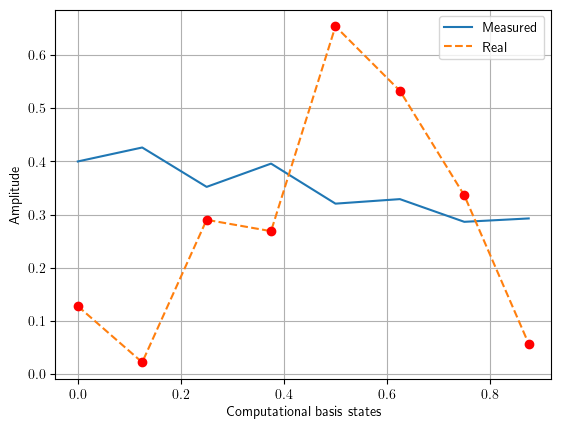

In [32]:
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
plt.plot(sample_points,np.sqrt(output),label='Measured')
plt.plot(sample_points,get_interp(amp_list)(sample_points),label='Real',linestyle='--')
plt.scatter(sample_points,amp_list,c='red',zorder=2)
plt.ylabel('Amplitude')
plt.xlabel('Computational basis states')
plt.legend()
plt.grid()
plt.show()

In [ ]:
max_error = []
prob = []
samples = np.linspace(1,10,num=10)
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
for e in samples:
    res2 = real_circuit(np.array(range(1,num_qubits+1)),np.array([0]),get_interp(amp_list),e,num_qubits)
    sum2 = 0
    for key,val in res2.items():
        if key[0]=='1':
            sum2+=val
    output2 = np.zeros(2**num_qubits)
    for key,val in res2.items():
        if key[0]=='1':
            output2[int(''.join(key[1:]),2)]+=val
    output2/=sum2
    prob.append(sum2/shots)
    max_error.append(np.max(np.abs(np.sqrt(output2)-get_interp(amp_list)(sample_points))))
plt.plot(samples,max_error,label='Max absolute error')
plt.plot(samples,prob,label='Success probability')
plt.xlabel(r'$\epsilon$',fontsize=15)
plt.legend()
plt.grid()
plt.show()

In [430]:
print(amp_list)

[0.12787755 0.02232474 0.29006564 0.26871596 0.65356168 0.53247637
 0.33595946 0.05709531]


In [12]:
real_job = service.jobs(backend_name='ibm_osaka')[0]

In [17]:
real_qc = real_job.inputs['circuits'][0]

In [23]:
dir(real_qc)

['__and__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iand__',
 '__init__',
 '__init_subclass__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '__xor__',
 '_ancillas',
 '_append',
 '_base_name',
 '_calibrations',
 '_check_dups',
 '_clbit_indices',
 '_clbits',
 '_control_flow_scopes',
 '_create_creg',
 '_create_qreg',
 '_data',
 '_global_phase',
 '_increment_instances',
 '_layout',
 '_metadata',
 '_name_update',
 '_op_start_times',
 '_parameter_table',
 '_parameters',
 '_peek_previous_instruction_in_scope',
 '_pop_previous_instruction_in_scope',
 '_pop_scope',
 '_push_scope',
 '_qubit_indices',
 '_qubits',
 '_resolve_classical_resource',
 '_unroll_param_dict',
 '_unsorted_paramete